## Problem
AI Track's Exercise to create a basic CNN to recognize different animals from the Chinese Zodiac

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Visualize a Batch of Training Data
* [Step 2](#step2): Create a CNN to recognize Chinese Zodiac  (from Scratch)
* [Step 3](#step3): Create a CNN to recognize Chinese Zodiac (using Transfer Learning)
* [Step 4](#step4): Write Algorithm
* [Step 5](#step5): Test Algorithm

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch import optim


In [0]:
%ls

In [10]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


<a id='step0'></a>
## Step 0: Import Datasets

Since the data already hosted in Kaggel, we can directly add data on the top right corner of this notebook.

In [11]:
# Mount Google Drive
from google.colab import drive

ROOT = "/content/drive"     # default for the drive
print(ROOT)

drive.mount(ROOT, force_remount=True)           # we mount the drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
%cd /content/drive/My\ Drive/MyDrive/Udacity/CNN\ Chinese\ Zodiac\ Signs

/content/drive/My Drive/MyDrive/Udacity/CNN Chinese Zodiac Signs


In [0]:
# uncomment if you want to create directory checkpoint, best_model
# %mkdir checkpoint best_model

In [5]:
%ls

 best_model/                      Network_architectures_1.png
 checkpoint/                      Network_architectures_2.png
'Chinese_Zodiac_Signs (1).gdoc'   Network_architectures.png
 Chinese_Zodiac_Signs.gdoc        serialized_model/
'Chinese Zodiac Signs.ipynb'      test_images/
 input/


In [0]:
#%rm ./input/chinese-zodiac-signs/signs/valid/tiger/00000576.jpg ./input/chinese-zodiac-signs/signs/valid/snake/serpant0015.jpg ./input/chinese-zodiac-signs/signs/valid/snake/00000576.jpg ./input/chinese-zodiac-signs/signs/train/rabbit/00000134.jpg ./input/chinese-zodiac-signs/signs/train/goat/00000582.jpg ./input/chinese-zodiac-signs/signs/train/monkey/00000585.jpg ./input/chinese-zodiac-signs/signs/train/snake/00000337.jpg ./input/chinese-zodiac-signs/signs/train/snake/00000116.jpg ./input/chinese-zodiac-signs/signs/train/rooster/00000216.jpg ./input/chinese-zodiac-signs/signs/train/pig/49476.html ./input/chinese-zodiac-signs/signs/train/pig/00000444.jpg

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

image_transformation = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# choose the training and test datasets
data_dir = './input/chinese-zodiac-signs'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

image_datasets = {
    'train' : ImageFolder(root=train_dir,transform=image_transformation['train']),
    'valid' : ImageFolder(root=valid_dir,transform=image_transformation['valid']),
    'test'  : ImageFolder(root=test_dir,transform=image_transformation['test']),
}

data_loaders = {
    'train' : DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True),
    'valid' : DataLoader(image_datasets['valid'],batch_size = batch_size,shuffle=True),
    'test'  : DataLoader(image_datasets['test'],batch_size = batch_size,shuffle=True),
}

In [0]:
# Empty lists
"""categories = []
img_train_categories = []
img_valid_categories = []
img_test_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(train_dir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(train_dir + '/' + d)
    valid_imgs = os.listdir(valid_dir + '/' +  d)
    test_imgs = os.listdir(test_dir + '/' +  d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_train_categories.append(d)
        img_file = train_dir + '/' + d + '/' + i
        if(img_file != './input/chinese-zodiac-signs/signs/train/rabbit/00000134.jpg' 
          and img_file != './input/chinese-zodiac-signs/signs/train/goat/00000582.jpg'
          and img_file != './input/chinese-zodiac-signs/signs/train/monkey/00000585.jpg'
          and img_file != './input/chinese-zodiac-signs/signs/train/snake/00000337.jpg'
          and img_file != './input/chinese-zodiac-signs/signs/train/snake/00000116.jpg'
          and img_file != './input/chinese-zodiac-signs/signs/train/rooster/00000216.jpg'
          and img_file != './input/chinese-zodiac-signs/signs/train/pig/49476.html'
          and img_file != './input/chinese-zodiac-signs/signs/train/pig/00000444.jpg'):
            img = Image.open(img_file)
            img_array = np.array(img)
            # Shape
            hs.append(img_array.shape[0])
            ws.append(img_array.shape[1])            
        
        
    # Find stats for validation images
    for i in valid_imgs:
        img_valid_categories.append(d)
        img_file = valid_dir + '/' + d + '/' + i
        if(img_file != './input/chinese-zodiac-signs/signs/valid/snake/serpant0015.jpg'
          and img_file != './input/chinese-zodiac-signs/signs/valid/snake/00000576.jpg'
          and img_file != './input/chinese-zodiac-signs/signs/valid/tiger/00000576.jpg'
          and img_file != './input/chinese-zodiac-signs/signs/valid/dragon/00000415.jpg'):
            img = Image.open(img_file)
            img_array = np.array(img)
            # Shape
            hs.append(img_array.shape[0])
            ws.append(img_array.shape[1])  
            
     # Find stats for validation images
    for i in test_imgs:
        img_test_categories.append(d)
        img_file = test_dir + '/' + d + '/' + i
        if(img_file != './input/chinese-zodiac-signs/signs/test/monkey/00000236.jpeg'):
            img = Image.open(img_file)
            img_array = np.array(img)
            # Shape
            hs.append(img_array.shape[0])
            ws.append(img_array.shape[1])          
        
# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 
                       'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
a = {'train category': img_train_categories,
    'height': hs,
    'width': ws}
image_df = pd.DataFrame.from_dict(a, orient='index')
image_df.transpose()

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()"""

,category,n_train,n_valid,n_test
9,rooster,599,54,55
4,goat,598,55,55
0,pig,598,54,55
8,rabbit,598,55,55
11,snake,598,52,55


In [0]:
#%cd '/kaggle/input/chinese-zodiac-signs/signs/train/rabbit/'

In [0]:
#im = Image.open("/kaggle/input/chinese-zodiac-signs/signs/train/goat/00000582.jpg")
#im.verify()

<a id='step1'></a>
## Step 1: Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [19]:
class_names = [item[0:].replace("_", " ") for item in image_datasets['train'].classes]
class_names

['dog',
 'dragon',
 'goat',
 'horse',
 'monkey',
 'ox',
 'pig',
 'rabbit',
 'ratt',
 'rooster',
 'snake',
 'tiger']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

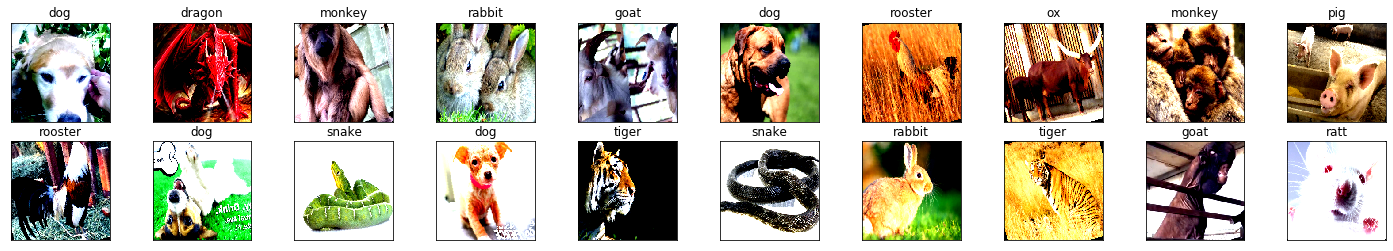

In [0]:
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[labels[idx]])

<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In [14]:
# check if CUDA is available
USE_GPU = True # currently GPU not available
use_cuda = USE_GPU and torch.cuda.is_available()
print(use_cuda)

True


In [0]:
import torchvision.models as models
import torch.nn as nn

### Model Mobilev2

In [91]:
## Specify model architecture 
model_transfer_mobilev2 = models.mobilenet_v2(pretrained=True)
    
print(model_transfer_mobilev2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [93]:
pip install torchsummary

In [94]:
# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

1 gpus detected.


In [0]:
# Freeze parameters so we don't backprop through them
for param in model_transfer_mobilev2.parameters():
    param.requires_grad = False

n_inputs = model_transfer_mobilev2.classifier[1].in_features
n_classes = len(class_names)
model_transfer_mobilev2.classifier = nn.Sequential(
                      nn.Dropout(0.2, inplace = False),
                      nn.Linear(n_inputs, n_classes, bias = True))

# Unfreeze training for classifier layers   
for param in model_transfer_mobilev2.classifier.parameters():
    param.requires_grad = True

In [0]:
if use_cuda:
    model_transfer_mobilev2 = model_transfer_mobilev2.cuda()

In [97]:
print(model_transfer_mobilev2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [98]:
# Useful for examining network
from torchsummary import summary
if USE_GPU and use_cuda:
    if multi_gpu:
        summary(
            model_transfer_mobilev2.module,
            input_size=(3, 224, 224),
            batch_size=batch_size,
            device='cuda')
    else:
        summary(
            model_transfer_mobilev2, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')
else:
    summary(
            model_transfer_mobilev2, input_size=(3, 224, 224), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [20, 32, 112, 112]             864
       BatchNorm2d-2         [20, 32, 112, 112]              64
             ReLU6-3         [20, 32, 112, 112]               0
            Conv2d-4         [20, 32, 112, 112]             288
       BatchNorm2d-5         [20, 32, 112, 112]              64
             ReLU6-6         [20, 32, 112, 112]               0
            Conv2d-7         [20, 16, 112, 112]             512
       BatchNorm2d-8         [20, 16, 112, 112]              32
  InvertedResidual-9         [20, 16, 112, 112]               0
           Conv2d-10         [20, 96, 112, 112]           1,536
      BatchNorm2d-11         [20, 96, 112, 112]             192
            ReLU6-12         [20, 96, 112, 112]               0
           Conv2d-13           [20, 96, 56, 56]             864
      BatchNorm2d-14           [20, 96,

In [0]:
# criterion and optimzier
from torch import optim
criterion_mobilev2h = nn.CrossEntropyLoss()
optimizer_mobilev2h = optim.Adam(model_transfer_mobilev2.classifier.parameters(), lr=0.001)

In [0]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [0]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # initialize train_loss_coll from checkpoint to train_loss_coll
    train_loss_coll = checkpoint['train_loss_coll']
    # initialize valid_loss_coll from checkpoint to valid_loss_coll
    valid_loss_coll = checkpoint['valid_loss_coll']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min, train_loss_coll, valid_loss_coll

In [0]:
def train(start_epochs, n_epochs, valid_loss_min_input, loaders, model, optimizer, criterion, use_cuda, checkpoint_path, best_model_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = valid_loss_min_input 
    
    train_loss_coll = []
    valid_loss_coll = []
    
    for epoch in range(start_epochs, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        train_correct = 0.
        train_total = 0.
        
        valid_loss = 0.0
        valid_correct = 0.
        valid_total = 0.        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (train_data, train_target) in enumerate(loaders['train']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                train_data, train_target = train_data.cuda(), train_target.cuda()
            # clear the gradients of all optimized variables    
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            train_output = model(train_data)
            # calculate the batch loss
            loss = criterion(train_output, train_target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update total training loss
            train_loss += loss.item()*train_data.size(0)            
            # convert output logits to predicted class
            train_pred = train_output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(train_pred.eq(train_target.data.view_as(train_pred))).cpu().numpy())
            train_total += train_data.size(0)
                
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for val_batch_idx, (val_data, val_target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                val_data, val_target = val_data.cuda(), val_target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            val_output = model(val_data)
            # calculate the batch loss
            val_loss = criterion(val_output, val_target)
            # update total validation loss 
            valid_loss += val_loss.item()*val_data.size(0)
            # convert output logits to predicted class
            valid_pred = val_output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(valid_pred.eq(val_target.data.view_as(valid_pred))).cpu().numpy())
            valid_total += val_data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        train_acc = 100. * train_correct / train_total
        valid_acc = 100. * valid_correct / valid_total
            
        # print training/validation statistics 
        print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f} \tTrain Acc: {:.2f} \tValid Acc: {:.2f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            train_acc,
            valid_acc))
        
        train_loss_coll.append(train_loss)
        valid_loss_coll.append(valid_loss)
        
        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_loss_coll':train_loss_coll,
            'valid_loss_coll':valid_loss_coll,
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
        ## Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss
            ))
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)    
            valid_loss_min = valid_loss   
            
    # return trained model
    return model, train_loss_coll, valid_loss_coll

In [0]:
model_transfer_mobilev2, train_loss_coll_mobilev2, valid_loss_coll_mobilev2 = train(1, 25, np.Inf, data_loaders, model_transfer_mobilev2, optimizer_mobilev2h, criterion_mobilev2h, use_cuda, "./checkpoint/current_checkpoint_mobilev2.pt", "./best_model/best_model_mobilev2.pt")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1 	Train Loss: 1.568911 	Valid Loss: 0.584078 	Train Acc: 60.85 	Valid Acc: 81.14
Validation loss decreased (inf --> 0.584078).  Saving model ...
Epoch: 2 	Train Loss: 0.536801 	Valid Loss: 0.375548 	Train Acc: 83.06 	Valid Acc: 88.87
Validation loss decreased (0.584078 --> 0.375548).  Saving model ...
Epoch: 3 	Train Loss: 0.425447 	Valid Loss: 0.333101 	Train Acc: 86.02 	Valid Acc: 87.94
Validation loss decreased (0.375548 --> 0.333101).  Saving model ...
Epoch: 4 	Train Loss: 0.395263 	Valid Loss: 0.294529 	Train Acc: 86.79 	Valid Acc: 89.03
Validation loss decreased (0.333101 --> 0.294529).  Saving model ...
Epoch: 5 	Train Loss: 0.367737 	Valid Loss: 0.295641 	Train Acc: 87.66 	Valid Acc: 89.49
Epoch: 6 	Train Loss: 0.350772 	Valid Loss: 0.270243 	Train Acc: 88.94 	Valid Acc: 91.65
Validation loss decreased (0.294529 --> 0.270243).  Saving model ...
Epoch: 7 	Train Loss: 0.334747 	Valid Loss: 0.251904 	Train Acc: 88.98 	Valid Acc: 91.81
Validation loss decreased (0.270243 -

In [4]:
# these arrays created manually based on training above because the value not saved once google colab loaded again or interrupted
# I make change to save and load method to save train_loss_coll and valid_loss_coll so that
# later on we don't need to create this manually anymore
train_loss_coll_mobilev2_loaded = []
train_loss_coll_mobilev2_loaded.append(1.568911)
train_loss_coll_mobilev2_loaded.append(0.536801)
train_loss_coll_mobilev2_loaded.append(0.425447)
train_loss_coll_mobilev2_loaded.append(0.395263)
train_loss_coll_mobilev2_loaded.append(0.367737)
train_loss_coll_mobilev2_loaded.append(0.350772)
train_loss_coll_mobilev2_loaded.append(0.334747)
train_loss_coll_mobilev2_loaded.append(0.331458)
train_loss_coll_mobilev2_loaded.append(0.316900)
train_loss_coll_mobilev2_loaded.append(0.310306)
train_loss_coll_mobilev2_loaded.append(0.311519)
train_loss_coll_mobilev2_loaded.append(0.293428)
train_loss_coll_mobilev2_loaded.append(0.307031)
train_loss_coll_mobilev2_loaded.append(0.289199)
train_loss_coll_mobilev2_loaded.append(0.284032)
train_loss_coll_mobilev2_loaded.append(0.310446)
train_loss_coll_mobilev2_loaded.append(0.287328)
train_loss_coll_mobilev2_loaded.append(0.306613)
train_loss_coll_mobilev2_loaded.append(0.300017)
train_loss_coll_mobilev2_loaded.append(0.292613)
train_loss_coll_mobilev2_loaded.append(0.282531)
train_loss_coll_mobilev2_loaded.append(0.295721)
train_loss_coll_mobilev2_loaded.append(0.278208)
train_loss_coll_mobilev2_loaded.append(0.275581)
train_loss_coll_mobilev2_loaded.append(0.300611)


valid_loss_coll_mobilev2_loaded = []
valid_loss_coll_mobilev2_loaded.append(0.584078)
valid_loss_coll_mobilev2_loaded.append(0.375548)
valid_loss_coll_mobilev2_loaded.append(0.333101)
valid_loss_coll_mobilev2_loaded.append(0.294529)
valid_loss_coll_mobilev2_loaded.append(0.295641)
valid_loss_coll_mobilev2_loaded.append(0.270243)
valid_loss_coll_mobilev2_loaded.append(0.251904)
valid_loss_coll_mobilev2_loaded.append(0.287743)
valid_loss_coll_mobilev2_loaded.append(0.267718)
valid_loss_coll_mobilev2_loaded.append(0.252412)
valid_loss_coll_mobilev2_loaded.append(0.258386)
valid_loss_coll_mobilev2_loaded.append(0.277846)
valid_loss_coll_mobilev2_loaded.append(0.261827)
valid_loss_coll_mobilev2_loaded.append(0.257734)
valid_loss_coll_mobilev2_loaded.append(0.259016)
valid_loss_coll_mobilev2_loaded.append(0.246643)
valid_loss_coll_mobilev2_loaded.append(0.253140)
valid_loss_coll_mobilev2_loaded.append(0.265003)
valid_loss_coll_mobilev2_loaded.append(0.243602)
valid_loss_coll_mobilev2_loaded.append(0.283308)
valid_loss_coll_mobilev2_loaded.append(0.331514)
valid_loss_coll_mobilev2_loaded.append(0.280837)
valid_loss_coll_mobilev2_loaded.append(0.267521)
valid_loss_coll_mobilev2_loaded.append(0.250385)
valid_loss_coll_mobilev2_loaded.append(0.273916)

print("Train Loss: {:.6f}".format(valid_loss_coll_mobilev2_loaded[1]))

Train Loss: 0.375548


In [103]:
print(model_transfer_mobilev2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [105]:
model_transfer_mobilev2, train_loss_coll_mobilev2, valid_loss_coll_mobilev2 = train(1, 25, np.Inf, data_loaders, model_transfer_mobilev2, optimizer_mobilev2h, criterion_mobilev2h, use_cuda, "./checkpoint/current_checkpoint_mobilev2.pt", "./best_model/best_model_mobilev2.pt")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1 	Train Loss: 0.425292 	Valid Loss: 0.295952 	Train Acc: 86.61 	Valid Acc: 89.34
Validation loss decreased (inf --> 0.295952).  Saving model ...
Epoch: 2 	Train Loss: 0.371286 	Valid Loss: 0.274422 	Train Acc: 87.65 	Valid Acc: 91.19
Validation loss decreased (0.295952 --> 0.274422).  Saving model ...
Epoch: 3 	Train Loss: 0.352919 	Valid Loss: 0.246933 	Train Acc: 88.11 	Valid Acc: 91.96
Validation loss decreased (0.274422 --> 0.246933).  Saving model ...
Epoch: 4 	Train Loss: 0.342864 	Valid Loss: 0.231448 	Train Acc: 89.00 	Valid Acc: 92.74
Validation loss decreased (0.246933 --> 0.231448).  Saving model ...
Epoch: 5 	Train Loss: 0.321413 	Valid Loss: 0.272789 	Train Acc: 89.37 	Valid Acc: 90.73
Epoch: 6 	Train Loss: 0.299698 	Valid Loss: 0.244372 	Train Acc: 90.28 	Valid Acc: 91.04
Epoch: 7 	Train Loss: 0.314361 	Valid Loss: 0.263974 	Train Acc: 89.19 	Valid Acc: 90.88
Epoch: 8 	Train Loss: 0.302646 	Valid Loss: 0.240826 	Train Acc: 89.76 	Valid Acc: 91.96
Epoch: 9 	Train L

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output logits to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [0]:
# load state of saved best model
ckp_path = './best_model/best_model_mobilev2.pt'
model_transfer_mobilev2, optimizer_mobilev2h, start_epoch, valid_loss_min, train_loss_coll_mobilev2, valid_loss_coll_mobilev2 = load_ckp(ckp_path, model_transfer_mobilev2, optimizer_mobilev2h)

In [115]:
print("model = ", model_transfer_mobilev2)
print("optimizer = ", optimizer_mobilev2h)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))

model =  MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, 

### Model ShuffleNetv2

In [0]:
model_shufflenetv2 = models.shufflenet_v2_x1_0(pretrained=True)
    
print(model_shufflenetv2)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [0]:
# Freeze parameters so we don't backprop through them
for param in model_shufflenetv2.parameters():
    param.requires_grad = False

n_inputs = model_shufflenetv2.fc.in_features
n_classes = len(class_names)
model_shufflenetv2.fc = nn.Linear(n_inputs, n_classes, bias = True)

# Unfreeze training for classifier layers   
for param in model_shufflenetv2.fc.parameters():
    param.requires_grad = True

In [0]:
if use_cuda:
    model_shufflenetv2 = model_shufflenetv2.cuda()

In [0]:
next(model_shufflenetv2.parameters()).is_cuda

True

In [0]:
print(model_shufflenetv2)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [0]:
# criterion and optimzier
from torch import optim
criterion_shufflenetv2 = nn.CrossEntropyLoss()
optimizer_shufflenetv2 = optim.Adam(model_shufflenetv2.fc.parameters(), lr=0.001)

In [0]:
model_shufflenetv2, train_loss_coll_shufflenetv2, valid_loss_coll_shufflenetv2 = train(1, 25, np.Inf, data_loaders, model_shufflenetv2, optimizer_shufflenetv2, criterion_shufflenetv2, use_cuda, "./checkpoint/current_checkpoint_shufflenetv2.pt", "./best_model/best_model_shufflenetv2.pt")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1 	Train Loss: 7.136982 	Valid Loss: 5.674315 	Train Acc: 2.02 	Valid Acc: 3.55
Validation loss decreased (inf --> 5.674315).  Saving model ...
Epoch: 2 	Train Loss: 4.377129 	Valid Loss: 4.338295 	Train Acc: 8.93 	Valid Acc: 8.35
Validation loss decreased (5.674315 --> 4.338295).  Saving model ...
Epoch: 3 	Train Loss: 3.546407 	Valid Loss: 3.608678 	Train Acc: 14.71 	Valid Acc: 13.76
Validation loss decreased (4.338295 --> 3.608678).  Saving model ...
Epoch: 4 	Train Loss: 3.040731 	Valid Loss: 3.122319 	Train Acc: 19.87 	Valid Acc: 19.32
Validation loss decreased (3.608678 --> 3.122319).  Saving model ...
Epoch: 5 	Train Loss: 2.670282 	Valid Loss: 2.714511 	Train Acc: 26.79 	Valid Acc: 24.88
Validation loss decreased (3.122319 --> 2.714511).  Saving model ...
Epoch: 6 	Train Loss: 2.358133 	Valid Loss: 2.405763 	Train Acc: 32.70 	Valid Acc: 32.61
Validation loss decreased (2.714511 --> 2.405763).  Saving model ...
Epoch: 7 	Train Loss: 2.125495 	Valid Loss: 2.157099 	Train A

In [0]:
# these arrays created manually based on training above because the value not saved once google colab loaded again or interrupted
# I make change to save and load method to save train_loss_coll and valid_loss_coll so that
# later on we don't need to create this manually anymore
train_loss_coll_shufflenetv2_loaded = []
train_loss_coll_shufflenetv2_loaded.append(7.136982)
train_loss_coll_shufflenetv2_loaded.append(4.377129)
train_loss_coll_shufflenetv2_loaded.append(3.546407)
train_loss_coll_shufflenetv2_loaded.append(3.040731)
train_loss_coll_shufflenetv2_loaded.append(2.670282)
train_loss_coll_shufflenetv2_loaded.append(2.358133)
train_loss_coll_shufflenetv2_loaded.append(2.125495)
train_loss_coll_shufflenetv2_loaded.append(1.916587)
train_loss_coll_shufflenetv2_loaded.append(1.774717)
train_loss_coll_shufflenetv2_loaded.append(1.648507)
train_loss_coll_shufflenetv2_loaded.append(1.521270)
train_loss_coll_shufflenetv2_loaded.append(1.445714)
train_loss_coll_shufflenetv2_loaded.append(1.384934)
train_loss_coll_shufflenetv2_loaded.append(1.320485)
train_loss_coll_shufflenetv2_loaded.append(1.253882)
train_loss_coll_shufflenetv2_loaded.append(1.191871)
train_loss_coll_shufflenetv2_loaded.append(1.151210)
train_loss_coll_shufflenetv2_loaded.append(1.115675)
train_loss_coll_shufflenetv2_loaded.append(1.078923)
train_loss_coll_shufflenetv2_loaded.append(1.048755)
train_loss_coll_shufflenetv2_loaded.append(1.012537)
train_loss_coll_shufflenetv2_loaded.append(0.991943)
train_loss_coll_shufflenetv2_loaded.append(0.955231)
train_loss_coll_shufflenetv2_loaded.append(0.946270)
train_loss_coll_shufflenetv2_loaded.append(0.931014)


valid_loss_coll_shufflenetv2_loaded = []
valid_loss_coll_shufflenetv2_loaded.append(5.674315)
valid_loss_coll_shufflenetv2_loaded.append(4.338295)
valid_loss_coll_shufflenetv2_loaded.append(3.608678)
valid_loss_coll_shufflenetv2_loaded.append(3.122319)
valid_loss_coll_shufflenetv2_loaded.append(2.714511)
valid_loss_coll_shufflenetv2_loaded.append(2.405763)
valid_loss_coll_shufflenetv2_loaded.append(2.157099)
valid_loss_coll_shufflenetv2_loaded.append(1.982034)
valid_loss_coll_shufflenetv2_loaded.append(1.813637)
valid_loss_coll_shufflenetv2_loaded.append(1.685187)
valid_loss_coll_shufflenetv2_loaded.append(1.577104)
valid_loss_coll_shufflenetv2_loaded.append(1.497572)
valid_loss_coll_shufflenetv2_loaded.append(1.404356)
valid_loss_coll_shufflenetv2_loaded.append(1.302281)
valid_loss_coll_shufflenetv2_loaded.append(1.266706)
valid_loss_coll_shufflenetv2_loaded.append(1.218365)
valid_loss_coll_shufflenetv2_loaded.append(1.164641)
valid_loss_coll_shufflenetv2_loaded.append(1.093461)
valid_loss_coll_shufflenetv2_loaded.append(1.061117)
valid_loss_coll_shufflenetv2_loaded.append(1.036347)
valid_loss_coll_shufflenetv2_loaded.append(0.994682)
valid_loss_coll_shufflenetv2_loaded.append(0.984856)
valid_loss_coll_shufflenetv2_loaded.append(0.936794)
valid_loss_coll_shufflenetv2_loaded.append(0.944247)
valid_loss_coll_shufflenetv2_loaded.append(0.908774)

In [0]:
# load state of saved best model
ckp_path = './best_model/best_model_shufflenetv2.pt'
model_shufflenetv2, optimizer_shufflenetv2, start_epoch, valid_loss_min = load_ckp(ckp_path, model_shufflenetv2, optimizer_shufflenetv2)

In [0]:
print("model = ", model_shufflenetv2)
print("optimizer = ", optimizer_shufflenetv2)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))

model =  ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track

###Model MNASNET

In [0]:
mnasnet = models.mnasnet1_0(pretrained=True)

In [0]:
print(mnasnet)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [0]:
# Freeze parameters so we don't backprop through them
for param in mnasnet.parameters():
    param.requires_grad = False

n_inputs = mnasnet.classifier[1].in_features
n_classes = len(class_names)
mnasnet.classifier = nn.Sequential(
                      nn.Dropout(0.2, inplace = True),
                      nn.Linear(n_inputs, n_classes, bias = True))

# Unfreeze training for classifier layers   
for param in mnasnet.classifier.parameters():
    param.requires_grad = True

In [0]:
if use_cuda:
    mnasnet = mnasnet.cuda()

In [133]:
next(mnasnet.parameters()).is_cuda

True

In [134]:
print(mnasnet)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [0]:
# criterion and optimzier
from torch import optim
criterion_mnasnet = nn.CrossEntropyLoss()
optimizer_mnasnet = optim.Adam(mnasnet.classifier.parameters(), lr=0.001)

In [136]:
mnasnet, train_loss_coll_mnasnet, valid_loss_coll_mnasnet = train(1, 50, np.Inf, data_loaders, mnasnet, optimizer_mnasnet, criterion_mnasnet, use_cuda, "./checkpoint/current_checkpoint_mnasnet.pt", "./best_model/best_model_mnasnet.pt")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1 	Train Loss: 0.903680 	Valid Loss: 0.347353 	Train Acc: 76.61 	Valid Acc: 88.72
Validation loss decreased (inf --> 0.347353).  Saving model ...
Epoch: 2 	Train Loss: 0.495824 	Valid Loss: 0.305611 	Train Acc: 85.48 	Valid Acc: 88.72
Validation loss decreased (0.347353 --> 0.305611).  Saving model ...
Epoch: 3 	Train Loss: 0.434674 	Valid Loss: 0.274993 	Train Acc: 86.58 	Valid Acc: 91.34
Validation loss decreased (0.305611 --> 0.274993).  Saving model ...
Epoch: 4 	Train Loss: 0.386891 	Valid Loss: 0.263900 	Train Acc: 87.52 	Valid Acc: 91.04
Validation loss decreased (0.274993 --> 0.263900).  Saving model ...
Epoch: 5 	Train Loss: 0.384876 	Valid Loss: 0.262156 	Train Acc: 87.50 	Valid Acc: 91.65
Validation loss decreased (0.263900 --> 0.262156).  Saving model ...
Epoch: 6 	Train Loss: 0.362985 	Valid Loss: 0.273837 	Train Acc: 88.01 	Valid Acc: 90.57
Epoch: 7 	Train Loss: 0.354499 	Valid Loss: 0.256227 	Train Acc: 88.36 	Valid Acc: 90.73
Validation loss decreased (0.262156 -

#### Serialized MNASET model for deployment

In [0]:
mnaset_loaded_model = models.mnasnet1_0(pretrained=True)

In [0]:
print(mnaset_loaded_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [0]:
n_inputs = mnaset_loaded_model.classifier[1].in_features
n_classes = len(class_names)
mnaset_loaded_model.classifier = nn.Sequential(
                      nn.Dropout(0.2, inplace = True),
                      nn.Linear(n_inputs, n_classes, bias = True))

In [0]:
print(mnaset_loaded_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [0]:
# load state of saved best model
ckp_path = './best_model/best_model_mnasnet.pt'
##checkpoint = torch.load(ckp_path, map_location=torch.device('cpu'))
# initialize state_dict from checkpoint to model
#mnaset_loaded_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [0]:
print(mnaset_loaded_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [0]:
# load state of saved best checkpoint
ckp_path = './best_model/best_model_mnasnet.pt'
best_model_loaded, optimizer_best, start_epoch, valid_loss_min, train_loss_coll_best, valid_loss_coll_best  = load_ckp(ckp_path, mnasnet, optimizer_mnasnet)

In [0]:
mnaset_loaded_model.eval()
example = torch.rand(1, 3, 224, 224)
if use_cuda:
  example = example.cuda()
traced_script_module = torch.jit.trace(best_model_loaded, example)
traced_script_module.save("./serialized_model/serialized_mnaset_model_v2.pt")

In [0]:
%pwd

'/content/drive/My Drive/MyDrive/Udacity/CNN Chinese Zodiac Signs'

In [0]:
# load state of saved best model
ckp_path = './best_model/best_model_mnasnet.pt'
model_mnasnet, optimizer_mnasnet, start_epoch, valid_loss_min, train_loss_coll_mnasnet, valid_loss_coll_mnasnet = load_ckp(ckp_path, mnasnet, optimizer_mnasnet)

In [127]:
print("model = ", model_mnasnet)
print("optimizer = ", optimizer_mnasnet)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))
print("train_loss_coll_mnasnet = ", train_loss_coll_mnasnet)
print("valid_loss_coll_mnasnet = ", valid_loss_coll_mnasnet)

model =  MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Co

### Model DenseNet

In [24]:
densenet = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:06<00:00, 19.1MB/s]


In [0]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
# Freeze parameters so we don't backprop through them
for param in densenet.parameters():
    param.requires_grad = False

n_inputs = densenet.classifier.in_features
n_classes = len(class_names)
densenet.classifier = nn.Linear(n_inputs, n_classes, bias = True)

# Unfreeze training for classifier layers   
for param in densenet.classifier.parameters():
    param.requires_grad = True

In [0]:
if use_cuda:
    densenet = densenet.cuda()

In [0]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
# criterion and optimzier
from torch import optim
criterion_densenet = nn.CrossEntropyLoss()
optimizer_densenet = optim.Adam(densenet.classifier.parameters(), lr=0.001)

In [0]:
densenet, train_loss_coll_densenet, valid_loss_coll_densenet = train(1, 25, np.Inf, data_loaders, densenet, optimizer_densenet, criterion_densenet, use_cuda, "./checkpoint/current_checkpoint_densenet.pt", "./best_model/best_model_densenet.pt")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1 	Train Loss: 0.621933 	Valid Loss: 0.261463 	Train Acc: 84.42 	Valid Acc: 93.35
Validation loss decreased (inf --> 0.261463).  Saving model ...
Validation loss decreased (0.261463 --> 0.216937).  Saving model ...
Epoch: 3 	Train Loss: 0.228576 	Valid Loss: 0.192575 	Train Acc: 93.09 	Valid Acc: 94.44
Validation loss decreased (0.216937 --> 0.192575).  Saving model ...
Epoch: 4 	Train Loss: 0.207432 	Valid Loss: 0.175405 	Train Acc: 93.74 	Valid Acc: 94.74
Validation loss decreased (0.192575 --> 0.175405).  Saving model ...
Epoch: 5 	Train Loss: 0.188368 	Valid Loss: 0.164516 	Train Acc: 94.02 	Valid Acc: 94.74
Validation loss decreased (0.175405 --> 0.164516).  Saving model ...
Epoch: 6 	Train Loss: 0.165812 	Valid Loss: 0.188890 	Train Acc: 94.90 	Valid Acc: 93.66
Epoch: 7 	Train Loss: 0.177626 	Valid Loss: 0.173835 	Train Acc: 94.23 	Valid Acc: 94.90
Epoch: 8 	Train Loss: 0.150281 	Valid Loss: 0.177204 	Train Acc: 95.08 	Valid Acc: 94.59
Epoch: 9 	Train Loss: 0.140786 	Valid

In [0]:
# load state of saved best model
ckp_path = './best_model/best_model_densenet.pt'
densenet, optimizer_densenet, start_epoch, valid_loss_min, train_loss_coll_densenet, valid_loss_coll_densenet  = load_ckp(ckp_path, densenet, optimizer_densenet)

In [0]:
print("model = ", densenet)
print("optimizer = ", optimizer_densenet)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))
print("train_loss_coll_densenet = ", train_loss_coll_densenet)
print("valid_loss_coll_densenet = ", valid_loss_coll_densenet)

model =  DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

### Model VGG16

In [31]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:22<00:00, 24.4MB/s]


In [0]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze parameters so we don't backprop through them
for param in vgg16.parameters():
    param.requires_grad = False

n_inputs = vgg16.classifier[6].in_features
n_classes = len(class_names)
vgg16.classifier[6] = nn.Linear(n_inputs, n_classes, bias = True)

# Unfreeze training for classifier layers   
for param in vgg16.classifier.parameters():
    param.requires_grad = True

In [16]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
if use_cuda:
    vgg16 = vgg16.cuda()
    
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# criterion and optimzier
criterion_vgg16 = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

In [0]:
#this training got interrupted, so we are going to load our latest saved checkpoint and continue training
#vgg16, train_loss_coll_vgg16, valid_loss_coll_vgg16 = train(1, 25, np.Inf, data_loaders, vgg16, optimizer_vgg16, criterion_vgg16, use_cuda, "./checkpoint/current_checkpoint_vgg16.pt", "./best_model/best_model_vgg16.pt")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1 	Train Loss: 1.423385 	Valid Loss: 0.796674 	Train Acc: 70.36 	Valid Acc: 81.45
Validation loss decreased (inf --> 0.796674).  Saving model ...
Epoch: 2 	Train Loss: 1.472027 	Valid Loss: 0.680259 	Train Acc: 76.56 	Valid Acc: 84.08
Validation loss decreased (0.796674 --> 0.680259).  Saving model ...
Epoch: 3 	Train Loss: 1.481787 	Valid Loss: 0.749719 	Train Acc: 79.11 	Valid Acc: 84.23
Epoch: 4 	Train Loss: 1.287455 	Valid Loss: 0.663754 	Train Acc: 81.25 	Valid Acc: 83.15
Validation loss decreased (0.680259 --> 0.663754).  Saving model ...


In [0]:
# Training above got interrupted so load the best model and continue
# load state of saved best model
ckp_path = './checkpoint/current_checkpoint_vgg16.pt'
vgg16, optimizer_vgg16, start_epoch, valid_loss_min, train_loss_coll_vgg16, valid_loss_coll_vgg16  = load_ckp(ckp_path, vgg16, optimizer_vgg16)

In [25]:
print("model = ", vgg16)
print("optimizer = ", optimizer_vgg16)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))
print("train_loss_coll_vgg16 = ", train_loss_coll_vgg16)
print("valid_loss_coll_vgg16 = ", valid_loss_coll_vgg16)

model =  VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [29]:
# continue training from epoch 5
vgg16, train_loss_coll_vgg16, valid_loss_coll_vgg16 = train(start_epoch, 25, valid_loss_min, data_loaders, vgg16, optimizer_vgg16, criterion_vgg16, use_cuda, "./checkpoint/current_checkpoint_vgg16.pt", "./best_model/best_model_vgg16.pt")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 5 	Train Loss: 1.266488 	Valid Loss: 0.643957 	Train Acc: 81.86 	Valid Acc: 87.79
Validation loss decreased (0.663754 --> 0.643957).  Saving model ...
Epoch: 6 	Train Loss: 1.098177 	Valid Loss: 0.739466 	Train Acc: 84.55 	Valid Acc: 86.55
Epoch: 7 	Train Loss: 0.927129 	Valid Loss: 0.694322 	Train Acc: 84.41 	Valid Acc: 88.10
Epoch: 8 	Train Loss: 0.951358 	Valid Loss: 0.626349 	Train Acc: 84.39 	Valid Acc: 87.02
Validation loss decreased (0.643957 --> 0.626349).  Saving model ...
Epoch: 9 	Train Loss: 0.754076 	Valid Loss: 0.770942 	Train Acc: 86.65 	Valid Acc: 86.24
Epoch: 10 	Train Loss: 0.950669 	Valid Loss: 0.717581 	Train Acc: 85.58 	Valid Acc: 86.71
Epoch: 11 	Train Loss: 0.879983 	Valid Loss: 0.645832 	Train Acc: 86.05 	Valid Acc: 86.40
Epoch: 12 	Train Loss: 0.815145 	Valid Loss: 0.756141 	Train Acc: 86.36 	Valid Acc: 87.64
Epoch: 13 	Train Loss: 0.709123 	Valid Loss: 0.847951 	Train Acc: 87.45 	Valid Acc: 87.48
Epoch: 14 	Train Loss: 0.790640 	Valid Loss: 0.595824 	Tr

In [0]:
# load state of saved best model
ckp_path = './best_model/best_model_vgg16.pt'
vgg16, optimizer_vgg16, start_epoch, valid_loss_min, train_loss_coll_vgg16, valid_loss_coll_vgg16  = load_ckp(ckp_path, vgg16, optimizer_vgg16)

## Inference

In [116]:
# Test the performance of the model with the lowest validation loss on the test data
test(data_loaders, model_transfer_mobilev2, criterion_mobilev2h, use_cuda)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.301537


Test Accuracy: 90% (595/658)


In [0]:
# Test the performance of the model with the lowest validation loss on the test data
test(data_loaders, model_shufflenetv2, criterion_shufflenetv2, use_cuda)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 1.068708


Test Accuracy: 70% (465/658)


In [137]:
# Test the performance of the model with the lowest validation loss on the test data
test(data_loaders, mnasnet, criterion_mnasnet, use_cuda)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.368574


Test Accuracy: 89% (587/658)


In [0]:
# Test the performance of the model with the lowest validation loss on the test data
test(data_loaders, densenet, criterion_densenet, use_cuda)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.196492


Test Accuracy: 93% (616/658)


In [32]:
# Test the performance of the model with the lowest validation loss on the test data
test(data_loaders, vgg16, criterion_vgg16, use_cuda)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.941419


Test Accuracy: 86% (569/658)


## Summary

In [0]:
# load state of saved current checkpoint
ckp_path = './checkpoint/current_checkpoint_mnasnet.pt'
mnasnet, optimizer_mnasnet, start_epoch, valid_loss_min, train_loss_coll_mnasnet, valid_loss_coll_mnasnet  = load_ckp(ckp_path, mnasnet, optimizer_mnasnet)

In [0]:
# load state of saved current checkpoint
ckp_path = './checkpoint/current_checkpoint_densenet.pt'
densenet, optimizer_densenet, start_epoch, valid_loss_min, train_loss_coll_densenet, valid_loss_coll_densenet  = load_ckp(ckp_path, densenet, optimizer_densenet)

In [0]:
# load state of saved current checkpoint
ckp_path = './checkpoint/current_checkpoint_vgg16.pt'
vgg16, optimizer_vgg16, start_epoch, valid_loss_min, train_loss_coll_vgg16, valid_loss_coll_vgg16  = load_ckp(ckp_path, vgg16, optimizer_vgg16)

In [37]:
print(train_loss_coll_vgg16)

[1.2664876123877327, 1.0981771974516734, 0.9271289729348886, 0.9513575905294097, 0.7540757357219289, 0.9506688479299953, 0.8799829916034887, 0.8151445293086059, 0.709122548881991, 0.7906396783790408, 0.7671132952045139, 0.8171055247595836, 0.7486723287753834, 0.7880257708501066, 0.6805530663895599, 0.5801869748128083, 0.739244789671689, 0.7432284551774986, 0.558272696199686, 0.8059571862553606, 0.6468120345718859]


In [0]:
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch: 1 	Train Loss: 1.423385 	Valid Loss: 0.796674 	Train Acc: 70.36 	Valid Acc: 81.45
Validation loss decreased (inf --> 0.796674).  Saving model ...
Epoch: 2 	Train Loss: 1.472027 	Valid Loss: 0.680259 	Train Acc: 76.56 	Valid Acc: 84.08
Validation loss decreased (0.796674 --> 0.680259).  Saving model ...
Epoch: 3 	Train Loss: 1.481787 	Valid Loss: 0.749719 	Train Acc: 79.11 	Valid Acc: 84.23
Epoch: 4 	Train Loss: 1.287455 	Valid Loss: 0.663754 	Train Acc: 81.25 	Valid Acc: 83.15
Validation loss decreased (0.680259 --> 0.663754).  Saving model ...

In [41]:
#manually added the interrupted training loss
train_loss_coll_vgg16.insert(0, 1.423385)
print(train_loss_coll_vgg16)

[1.423385, 1.472027, 1.481787, 1.287455, 1.2664876123877327, 1.0981771974516734, 0.9271289729348886, 0.9513575905294097, 0.7540757357219289, 0.9506688479299953, 0.8799829916034887, 0.8151445293086059, 0.709122548881991, 0.7906396783790408, 0.7671132952045139, 0.8171055247595836, 0.7486723287753834, 0.7880257708501066, 0.6805530663895599, 0.5801869748128083, 0.739244789671689, 0.7432284551774986, 0.558272696199686, 0.8059571862553606, 0.6468120345718859]


In [51]:
#manually added the interrupted validation loss
del valid_loss_coll_vgg16[1]
#valid_loss_coll_vgg16.insert(0, 0.796674)
print(valid_loss_coll_vgg16)

[0.796674, 0.680259, 0.749719, 0.663754, 0.6439572198221452, 0.7394660050985065, 0.6943219211961933, 0.6263493596125607, 0.7709419766478863, 0.7175809115249163, 0.6458318985918021, 0.7561408526838471, 0.8479511762466828, 0.595823755283398, 0.6522889671475847, 0.5344583016274701, 0.48477747055832904, 0.7116085233805929, 0.5645366590210975, 0.774494198019943, 0.5801748325688393, 0.534259793125496, 0.6706775534189835, 0.5039801951814584, 0.6339266635995744]


<Figure size 432x288 with 0 Axes>

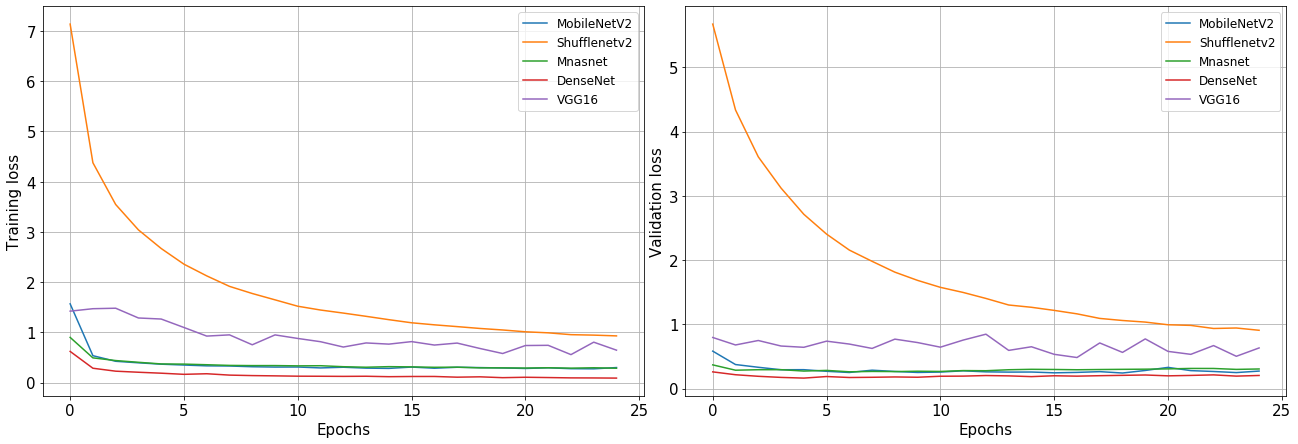

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

epochs = range(0,25)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
fsize = 15

#ax1.plot(epochs, train_loss_coll_mobilev2, label='MobileNetV2')
ax1.plot(epochs, train_loss_coll_mobilev2_loaded, label='MobileNetV2')
#ax1.plot(epochs, train_loss_coll_shufflenetv2, label='Shufflenetv2')
ax1.plot(epochs, train_loss_coll_shufflenetv2_loaded, label='Shufflenetv2')
ax1.plot(epochs, train_loss_coll_mnasnet, label='Mnasnet')
ax1.plot(epochs, train_loss_coll_densenet, label='DenseNet')
ax1.plot(epochs, train_loss_coll_vgg16, label='VGG16')
ax1.set_xlabel('Epochs', fontsize = fsize)
ax1.set_ylabel('Training loss', fontsize = fsize)
ax1.legend()
ax1.tick_params(labelsize = fsize)
ax1.grid()
ax1.legend(fontsize = 12)

#ax2.plot(epochs, valid_loss_coll_mobilev2, label='MobileNetV2')
ax2.plot(epochs, valid_loss_coll_mobilev2_loaded, label='MobileNetV2')
#ax2.plot(epochs, valid_loss_coll_shufflenetv2, label='Shufflenetv2')
ax2.plot(epochs, valid_loss_coll_shufflenetv2_loaded, label='Shufflenetv2')
ax2.plot(epochs, valid_loss_coll_mnasnet, label='Mnasnet')
ax2.plot(epochs, valid_loss_coll_densenet, label='DenseNet')
ax2.plot(epochs, valid_loss_coll_vgg16, label='VGG16')
ax2.set_xlabel('Epochs', fontsize = fsize)
ax2.set_ylabel('Validation loss', fontsize = fsize)
ax2.legend()
ax2.tick_params(labelsize = fsize)
ax2.grid()
ax2.legend(fontsize = 12)

plt.savefig('Network_architectures.png', bbox_inches='tight', orientation='landscape', dpi=300)

<a id='step4'></a>
## Step 4: Write Algorithm

In [0]:
from torch.autograd import Variable
def predict_chinesee_zodiac_sign_tl_model(img_path, model, use_cuda, class_names):
    # load the image and return the predicted breed
    imsize = 224
    loader = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(imsize),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    image = Image.open(img_path)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    if use_cuda:        
        image = image.cuda()   

    output = model(image)

    _, preds_tensor = torch.max(output, 1) # convert output probabilities to predicted class
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

In [0]:
# load state of saved best checkpoint
ckp_path = './best_model/best_model_mnasnet.pt'
best_model, optimizer_best, start_epoch, valid_loss_min, train_loss_coll_best, valid_loss_coll_best  = load_ckp(ckp_path, mnasnet, optimizer_mnasnet)

In [69]:
print(valid_loss_min)

0.2625579375779426


In [0]:
def run_app(img_path):
    
    title_message = 'Sorry, I don\'t know your chinese zodiac sign!'
        
    chinese_zodiac_sign = predict_chinesee_zodiac_sign_tl_model(img_path, best_model, use_cuda, class_names)
    title_message = 'Your chinese zodiac sign is ...\n' + chinese_zodiac_sign       
    
    plt.figure()
    plt.imshow(Image.open(img_path))
    plt.title(title_message)
    plt.show()

<a id='step5'></a>
## Step 5: Test Algorithm

In [140]:
from glob import glob
# load filenames for testing
test_images = np.array(glob("./test_images/*"))

# print number of images in folder
print('There are %d total test images.' % len(test_images))

There are 6 total test images.


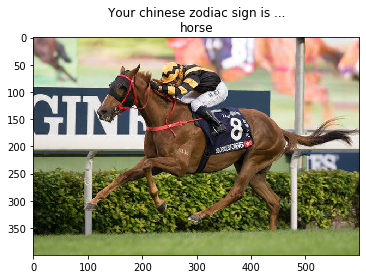

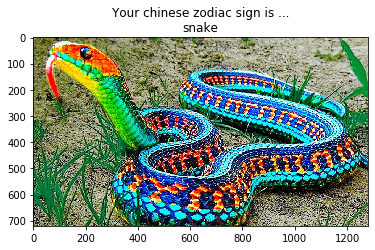

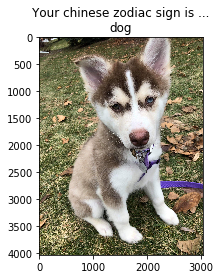

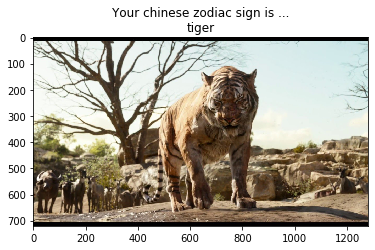

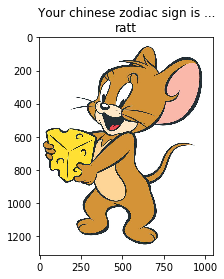

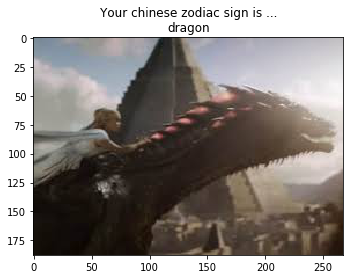

In [141]:
n = [0, 1, 2, 3, 4, 5]
for file in np.hstack((test_images[n])):
    run_app(file)

### Issue
* RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0
     * solution: make width and height of the image is the same; use resize or centerCrop
* Download pytorch pre-train model: URLError: <urlopen error [Errno -3] Temporary failure in name resolution>
     * solution: enable internet connection in kaggle docker
* OSError: cannot identify image file '/kaggle/input/chinese-zodiac-signs/signs/train/rabbit/00000134.jpg'
     * ImageFile.LOAD_TRUNCATED_IMAGES = True